In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pandas as pd

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
# Define label mapping for classes
label_map = {
    "tetragonal": 0,
    "orthorhombic": 1,
    "trigonal": 2,
    "cubic": 3,
    "triclinic": 4,
    "monoclinic": 5,
    "hexagonal": 6
}

# Label names
label_names = [
    "tetragonal", "orthorhombic", "trigonal", 
    "cubic", "triclinic", "monoclinic", "hexagonal"
]

csv_path = "/Users/wasslu/Desktop/NTU/MLPhys/ML-course/testdata/structure_info.csv"
data_dir = "/Users/wasslu/Desktop/NTU/MLPhys/ML-course/output_data"
df = pd.read_csv(csv_path)

In [ ]:
# Preprocessing function
def load_xrd_data(file_list, data_dir):
    X, y = [], []
    for file_name, label in file_list:
        file_name = file_name.replace('.cif', '_convolved.npz')
        file_path = os.path.join(data_dir, file_name)

        # Load intensity data
        if os.path.exists(file_path):
            data = np.load(file_path)
            x = data['y_convolved'].astype(np.float32)  # Use intensity data
            X.append(x)
            y.append(label_map[label])
    return np.array(X), np.array(y)


In [19]:
# Split the data into train, test, and validation sets
split_info = {
    "tetragonal": (3000, 500, 100),
    "orthorhombic": (3000, 500, 300),
    "trigonal": (2000, 500, 100),
    "cubic": (2000, 500, 100),
    "triclinic": (1800, 500, 100),
    "monoclinic": (3000, 500, 300),
    "hexagonal": (100, 10, 5)
}

train_list, test_list, val_list = [], [], []
for label, (train_size, test_size, val_size) in split_info.items():
    files = df[df['cell_structure'] == label][['filename', 'cell_structure']].values.tolist()

    # Split into training, testing, and validation sets
    train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
    test_files, temp_files = train_test_split(temp_files, train_size=test_size, random_state=42)
    val_files, _ = train_test_split(temp_files, train_size=val_size, random_state=42)

    train_list.extend(train_files)
    test_list.extend(test_files)
    val_list.extend(val_files)

In [20]:
# Load the datasets
X_train, y_train = load_xrd_data(train_list, data_dir)
X_test, y_test = load_xrd_data(test_list, data_dir)
X_val, y_val = load_xrd_data(val_list, data_dir)

# Flatten the feature vectors
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

In [12]:
class XRDDataset(Dataset):
    """Custom Dataset for XRD Pattern Classification"""
    def __init__(self, features, labels):
        """
        Args:
            features (numpy array): Input XRD pattern features
            labels (numpy array): Corresponding labels
        """
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class PositionalEncoding(nn.Module):
    """Positional Encoding for Transformer"""
    def __init__(self, d_model, max_len=100):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(1), :]

In [42]:
class XRDTransformer(nn.Module):
    """Transformer Model for XRD Pattern Classification"""
    def __init__(self, input_dim, d_model, nhead, num_layers, num_classes):
        """
        Args:
            input_dim (int): Dimension of input XRD pattern features
            d_model (int): Transformer model dimension
            nhead (int): Number of attention heads
            num_layers (int): Number of transformer layers
            num_classes (int): Number of classification classes
        """
        super().__init__()
        
        # Input projection to model dimension
        self.input_projection = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU()
        )
        
        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model)
        
        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=d_model * 4,
            dropout=0.5,
            activation='relu'
        )
        
        # Full Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        
        # Project input to model dimension
        x = self.input_projection(x.unsqueeze(1)).squeeze(1)
        
        # Add positional encoding
        x = self.positional_encoding(x.unsqueeze(0)).squeeze(0)
        
        # Transformer encoding
        x = self.transformer_encoder(x.unsqueeze(0)).squeeze(0)
        
        # Classify
        return self.classifier(x)

In [7]:
def train_xrd_classifier(model, train_loader, val_loader, criterion, optimizer, 
                          device, num_epochs=50, patience=10):
    """
    Training function for XRD Transformer with early stopping
    
    Args:
        model (nn.Module): Transformer model
        train_loader (DataLoader): Training data loader
        val_loader (DataLoader): Validation data loader
        criterion (nn.Module): Loss function
        optimizer (torch.optim): Optimizer
        device (torch.device): Computing device
        num_epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
    
    Returns:
        dict: Training history with loss and accuracy
    """
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }
    
    # Early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Compute training metrics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                # Compute validation metrics
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Compute average losses and accuracies
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = train_correct / train_total * 100
        val_accuracy = val_correct / val_total * 100
        
        # Store history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
        print(f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save best model
            torch.save(model.state_dict(), 'best_xrd_transformer.pth')
        else:
            epochs_no_improve += 1
        
        # Stop if no improvement
        if epochs_no_improve >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return history

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation loss/accuracy
    
    Args:
        history (dict): Training history dictionary
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_accuracy'], label='Train Accuracy')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_percentage_confusion_matrix(y_true, y_pred, label_names):
    """
    Plot a confusion matrix with percentages and improved readability
    
    Args:
        y_true (array-like): True labels
        y_pred (array-like): Predicted labels
        label_names (list): List of class names
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true') * 100
    
    # Create figure and axes
    plt.figure(figsize=(8, 6))
    
    # Use seaborn for enhanced visualization
    sns.heatmap(cm, 
                annot=True, 
                fmt='.1f', 
                cmap='Blues', 
                xticklabels=label_names, 
                yticklabels=label_names)
    
    plt.title('Confusion Matrix (Percentage)', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    plt.show()


In [11]:
from sklearn.metrics import classification_report

def evaluate_model(model, test_loader, device, label_names):
    """
    Comprehensive model evaluation
    
    Args:
        model (nn.Module): Trained model
        test_loader (DataLoader): Test data loader
        device (torch.device): Computing device
        label_names (list): List of class names
    
    Returns:
        tuple: Confusion matrix and classification report
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Plot percentage confusion matrix
    plot_percentage_confusion_matrix(all_labels, all_preds, label_names)
    
    # Generate classification report
    report = classification_report(all_labels, all_preds, target_names=label_names)
    print("Classification Report:\n", report)
    
    return report

In [45]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_dim = X_train.shape[1]  # From your feature extraction
num_classes = 7  # Number of crystal structure classes
batch_size = 64
learning_rate = 0.0001

# Create DataLoaders
train_dataset = XRDDataset(X_train, y_train)
val_dataset = XRDDataset(X_val, y_val)
test_dataset = XRDDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model
model = XRDTransformer(
    input_dim=input_dim, 
    d_model=64,  # Transformer model dimension 
    nhead=8,     # Number of attention heads
    num_layers=2,# Number of transformer layers
    num_classes=num_classes
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train the model
history = train_xrd_classifier(
    model, train_loader, val_loader, 
    criterion, optimizer, device, num_epochs=100, patience=100
)

# Plot training history
plot_training_history(history)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch [1/100]
Train Loss: 1.8926, Train Acc: 19.18%
Val Loss: 1.7885, Val Acc: 18.91%
Epoch [2/100]
Train Loss: 1.8590, Train Acc: 19.63%
Val Loss: 1.7667, Val Acc: 19.00%
Epoch [3/100]
Train Loss: 1.8470, Train Acc: 19.95%
Val Loss: 1.7584, Val Acc: 21.29%
Epoch [4/100]
Train Loss: 1.8348, Train Acc: 19.79%
Val Loss: 1.7501, Val Acc: 28.66%
Epoch [5/100]
Train Loss: 1.8318, Train Acc: 19.63%
Val Loss: 1.7532, Val Acc: 27.76%
Epoch [6/100]
Train Loss: 1.8256, Train Acc: 19.70%
Val Loss: 1.7464, Val Acc: 27.66%
Epoch [7/100]
Train Loss: 1.8220, Train Acc: 19.44%
Val Loss: 1.7549, Val Acc: 13.93%
Epoch [8/100]
Train Loss: 1.8191, Train Acc: 20.36%
Val Loss: 1.7483, Val Acc: 29.75%
Epoch [9/100]
Train Loss: 1.8134, Train Acc: 20.37%
Val Loss: 1.7478, Val Acc: 29.75%
Epoch [10/100]
Train Loss: 1.8121, Train Acc: 19.97%
Val Loss: 1.7522, Val Acc: 24.28%
Epoch [11/100]
Train Loss: 1.8117, Train Acc: 20.34%
Val Loss: 1.7489, Val Acc: 29.45%
Epoch [12/100]
Train Loss: 1.8109, Train Acc: 20.26%

KeyboardInterrupt: 

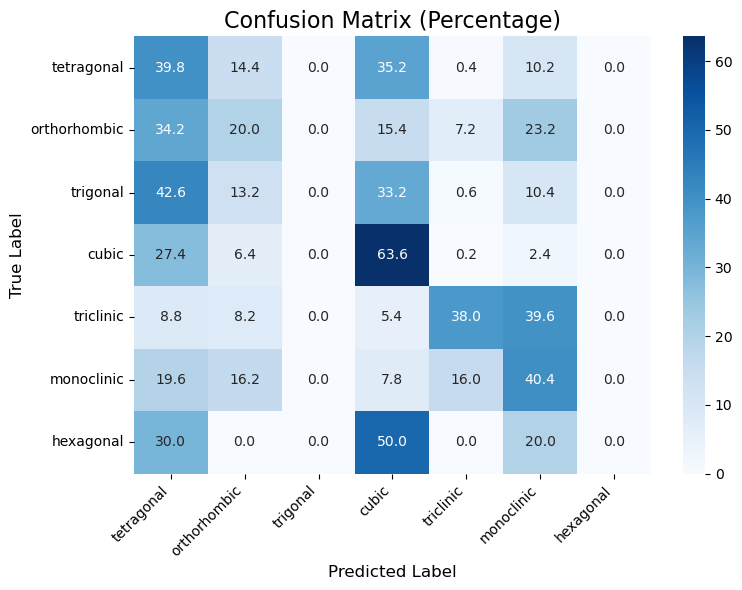

Classification Report:
               precision    recall  f1-score   support

  tetragonal       0.23      0.40      0.29       500
orthorhombic       0.26      0.20      0.22       500
    trigonal       0.00      0.00      0.00       500
       cubic       0.39      0.64      0.49       500
   triclinic       0.61      0.38      0.47       500
  monoclinic       0.32      0.40      0.36       500
   hexagonal       0.00      0.00      0.00        10

    accuracy                           0.34      3010
   macro avg       0.26      0.29      0.26      3010
weighted avg       0.30      0.34      0.30      3010



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


'              precision    recall  f1-score   support\n\n  tetragonal       0.23      0.40      0.29       500\northorhombic       0.26      0.20      0.22       500\n    trigonal       0.00      0.00      0.00       500\n       cubic       0.39      0.64      0.49       500\n   triclinic       0.61      0.38      0.47       500\n  monoclinic       0.32      0.40      0.36       500\n   hexagonal       0.00      0.00      0.00        10\n\n    accuracy                           0.34      3010\n   macro avg       0.26      0.29      0.26      3010\nweighted avg       0.30      0.34      0.30      3010\n'

In [44]:
evaluate_model(model, test_loader, device, label_names)